In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import f1_score
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import StratifiedKFold

In [3]:
path="/Users/capucinerousset/Desktop/statapp_sujet26/"
file_name1="dataset_complet_part_1.csv"
file_name2="dataset_complet_part_2.csv"
df1 = pd.read_csv(path+file_name1, sep=',',low_memory=False)
df2 = pd.read_csv(path+file_name2, sep=',',low_memory=False)
df = pd.concat([df1,df2])

df = df.loc[df['an'] == 2019]
df['grav'] = df['grav'].replace({1:0,2:0,3:1,4:1})

#Dummy heure de pointe
def is_peak_hour(hour_minute):
    hour, minute = map(int, hour_minute.split(':'))
    total_minutes = hour * 60 + minute
    peak_hours = [(7, 0), (10, 0), (16, 30), (19, 30)]
    for start, end in zip(peak_hours[:-1], peak_hours[1:]):
        start_minutes = start[0] * 60 + start[1]
        end_minutes = end[0] * 60 + end[1]
        if start_minutes <= total_minutes < end_minutes:
            return 1
    return 0
df['HP_ind'] = df['hrmn'].apply(is_peak_hour)

#Dummy jour de semaine
df['date'] = pd.to_datetime({'year': 2019, 'month': df['mois'], 'day': df['jour']})
df['jour_de_semaine'] = df['date'].dt.day_name()
df = pd.get_dummies(df, columns=['jour_de_semaine'], prefix='jour', dtype=int)



#Dummy plage horaire
'''def plage_horaire(heure):
    if 5 <= heure < 12:
        return 'matin'
    elif 12 <= heure < 14:
        return 'midi'
    elif 14 <= heure < 18:
        return 'après-midi'
    elif 18 <= heure < 22:
        return 'soir'
    else:
        return 'nuit'

df['plage_horaire'] = df['hrmn'].apply(plage_horaire)
df = pd.get_dummies(df, columns=['plage_horaire'], prefix='plage_horaire', dtype=int)'''


#Dummy jour férié : 
df['date'] = pd.to_datetime({'year': 2019, 'month': df['mois'], 'day': df['jour']})

jours_feries_2019 = [
    '2019-01-01', '2019-04-22', '2019-05-01', '2019-05-08', '2019-05-30', 
    '2019-06-10', '2019-07-14', '2019-08-15', '2019-11-01', '2019-11-11', '2019-12-25'
]

df['jour_ferie'] = df['date'].isin(pd.to_datetime(jours_feries_2019)).astype(int)

#Vacances scolaires en 2019
vacances_2019 = [
    # Vacances d'hiver
    ('2019-02-16', '2019-03-03'),
    ('2019-02-09', '2019-02-24'),
    ('2019-02-23', '2019-03-10'),
    # Vacances de printemps
    ('2019-04-13', '2019-04-28'),
    ('2019-04-06', '2019-04-22'),
    ('2019-04-20', '2019-05-05'),
    # Vacances d'été
    ('2019-07-06', '2019-09-01'),
    # Vacances de la Toussaint
    ('2019-10-19', '2019-11-04'),
    # Vacances de Noël
    ('2019-12-21', '2019-12-31')
]

#Dummy vacances scolaires
df['vacances_scolaires'] = 0
for start, end in vacances_2019:
    df.loc[(df['date'] >= start) & (df['date'] <= end), 'vacances_scolaires'] = 1

#Dummy mois
df['mois'] = df['mois'].replace({1.:'janvier',2.:'février',3.:'mars',4.:'avril',5.:'mai',6.:'juin',7.:'juillet',8.:'août',9.:'septembre',10.:'octobre',11.:'novembre',12.:'décembre'})
df = pd.get_dummies(df, columns=['mois'], prefix='mois', dtype=int)

# Dummy pour les variables spécifiées, en excluant les valeurs égales à -1 : celles qui ont pas de sens (valeur num )
columns_to_dummy = ['lum', 'agg', 'int', 'atm', 'catr', 'circ', 'prof', 'plan', 'surf', 'situ', 'infra']
 
for column in columns_to_dummy:
        df = pd.get_dummies(df, columns=[column], prefix=[column], dtype=int)

# Dummy département
def assign_region(dep_code):
    regions = {
        '1': 'Auvergne-Rhône-Alpes',
        '2': 'Hauts-de-France',
        '3': 'Auvergne-Rhône-Alpes',
        '4': 'PACA',
        '5': 'PACA',
        '6': 'PACA',
        '7': 'Auvergne-Rhône-Alpes',
        '8': 'Grand Est',
        '9': 'Occitanie',
        '10': 'Grand Est',
        '11': 'Occitanie',
        '12': 'Occitanie',
        '13': 'PACA',
        '14': 'Normandie',
        '15': 'Auvergne-Rhône-Alpes',
        '16': 'Nouvelle-Aquitaine',
        '17': 'Nouvelle-Aquitaine',
        '18': 'Centre-Val de Loire',
        '19': 'Nouvelle-Aquitaine',
        '2A': 'Corse',
        '2B': 'Corse',
        '21': 'Bourgogne-Franche-Comté',
        '22': 'Bretagne',
        '23': 'Nouvelle-Aquitaine',
        '24': 'Nouvelle-Aquitaine',
        '25': 'Bourgogne-Franche-Comté',
        '26': 'Auvergne-Rhône-Alpes',
        '27': 'Normandie',
        '28': 'Centre-Val de Loire',
        '29': 'Bretagne',
        '30': 'Occitanie',
        '31': 'Occitanie',
        '32': 'Occitanie',
        '33': 'Nouvelle-Aquitaine',
        '34': 'Occitanie',
        '35': 'Bretagne',
        '36': 'Centre-Val de Loire',
        '37': 'Centre-Val de Loire',
        '38': 'Auvergne-Rhône-Alpes',
        '39': 'Bourgogne-Franche-Comté',
        '40': 'Nouvelle-Aquitaine',
        '41': 'Centre-Val de Loire',
        '42': 'Auvergne-Rhône-Alpes',
        '43': 'Auvergne-Rhône-Alpes',
        '44': 'Pays de la Loire',
        '45': 'Centre-Val de Loire',
        '46': 'Occitanie',
        '47': 'Nouvelle-Aquitaine',
        '48': 'Occitanie',
        '49': 'Pays de la Loire',
        '50': 'Normandie',
        '51': 'Grand Est',
        '52': 'Grand Est',
        '53': 'Pays de la Loire',
        '54': 'Grand Est',
        '55': 'Grand Est',
        '56': 'Bretagne',
        '57': 'Grand Est',
        '58': 'Bourgogne-Franche-Comté',
        '59': 'Hauts-de-France',
        '60': 'Hauts-de-France',
        '61': 'Normandie',
        '62': 'Hauts-de-France',
        '63': 'Auvergne-Rhône-Alpes',
        '64': 'Nouvelle-Aquitaine',
        '65': 'Occitanie',
        '66': 'Occitanie',
        '67': 'Grand Est',
        '68': 'Grand Est',
        '69': 'Auvergne-Rhône-Alpes',
        '70': 'Bourgogne-Franche-Comté',
        '71': 'Bourgogne-Franche-Comté',
        '72': 'Pays de la Loire',
        '73': 'Auvergne-Rhône-Alpes',
        '74': 'Auvergne-Rhône-Alpes',
        '75': 'Île-de-France',
        '76': 'Normandie',
        '77': 'Île-de-France',
        '78': 'Île-de-France',
        '79': 'Nouvelle-Aquitaine',
        '80': 'Hauts-de-France',
        '81': 'Occitanie',
        '82': 'Occitanie',
        '83': 'PACA',
        '84': 'PACA',
        '85': 'Pays de la Loire',
        '86': 'Nouvelle-Aquitaine',
        '87': 'Nouvelle-Aquitaine',
        '88': 'Grand Est',
        '89': 'Bourgogne-Franche-Comté',
        '90': 'Bourgogne-Franche-Comté',
        '91': 'Île-de-France',
        '92': 'Île-de-France',
        '93': 'Île-de-France',
        '94': 'Île-de-France',
        '95': 'Île-de-France',
        '971': 'Outre Mer',
        '972': 'Outre Mer',
        '973': 'Outre Mer',
        '974': 'Outre Mer',
        '976': 'Outre Mer',
        '977' : 'Collectivité Outre Mer', 
        '978' : 'Collectivité Outre Mer', 
        '986' : 'Collectivité Outre Mer', 
        '987' : 'Collectivité Outre Mer', 
        '988' : 'Collectivité Outre Mer',
        '2A' : 'Corse',
        '2B' : 'Corse',

    }
    return regions.get(dep_code[:2], 'Autre')

df['region'] = df['dep'].apply(assign_region)
#j'ai verif tout a été fill out avec les régions (pas de valeurs manquantes ds région)

df = pd.get_dummies(df, columns=['region'], prefix='region', dtype=int)

df = df.drop(columns=['Num_Acc','an','adr','lat','long','lartpc','larrout','com','gps','voie','dep','v2','pr','pr1','date'])
#ici on enlève an car on ne regarde que pour 2019
df['hrmn'] = df['hrmn'].str.split(':').str[0]

df.to_csv('lin2.csv', index=False)

y = df['grav']
X = df.drop(columns=['grav'])
features = X.columns

In [4]:
# Diviser le jeu de données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

#Inférer les valeurs non renseignées
imputer = SimpleImputer(strategy='median')
X_train_imp = imputer.fit_transform(X_train)
X_test_imp = imputer.transform(X_test)

#Ajuster Y pour fitter avec la nouvelle base de features
y_train = y_train.loc[X_train.index]
y_test = y_test.loc[X_test.index]

#Créer le modèle linéaire et l'entrainer sur les bases test
model = LinearRegression()
model.fit(X_train_imp, y_train)

#Tester le modèle sur la base de features test
y_pred = model.predict(X_test_imp)

for i in range(len(y_pred)):
    if y_pred[i]>(1/2):
        y_pred[i]=int(1)
    else: y_pred[i]=int(0)



In [5]:
# Calculer le score f1 du modèle
f1 = f1_score(y_test, y_pred)
print("F1:", f1)

F1: 0.5948680881821466


In [6]:
# On récupère les coefficients
coefficients = model.coef_

# Les associer à leur feature 
feature_importance = list(zip(features, coefficients))


# Trier les coefficients par valeur absolue
feature_importance_sorted = sorted(feature_importance, key=lambda x: abs(x[1]), reverse=True)

# Afficher les 10 coefficients les plus importants
print("10 most important coefficients:")
for i in range(10):
    feature, importance = feature_importance_sorted[i]
    print(f"{feature}: {importance}")

10 most important coefficients:
atm_-1.0: 0.3964366612215531
region_Île-de-France: -0.20692492137234975
plan_-1.0: 0.19869870415830773
int_8.0: 0.17168121479642265
infra_7.0: 0.14181189156920684
catr_1.0: -0.1386142904101472
surf_4.0: -0.12658133780569278
surf_5.0: -0.12459917456512967
situ_4.0: 0.11482229933701803
situ_-1.0: -0.1130971828869089


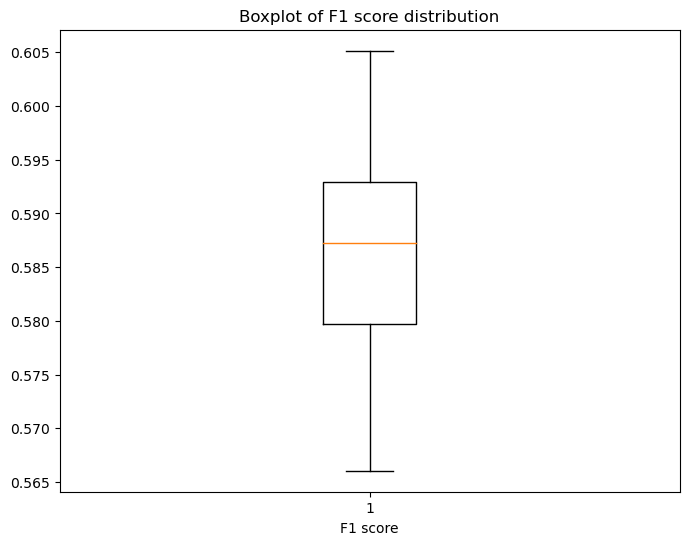

In [7]:
skf = StratifiedKFold(n_splits=20, random_state=42, shuffle=True)

lr_model = LinearRegression()

f1s= []


# Iterate through each fold
for train_index, test_index in skf.split(X, y):
    X_train2, X_test2 = X.iloc[train_index], X.iloc[test_index]
    y_train2, y_test2 = y.iloc[train_index], y.iloc[test_index]

    imputer = SimpleImputer(strategy='mean')
    X_train_imp2 = imputer.fit_transform(X_train2)
    X_test_imp2 = imputer.transform(X_test2)
    
    # Fit the model
    lr_model.fit(X_train_imp2, y_train2)
    
    # Predict on the test set
    y_pred2 = lr_model.predict(X_test_imp2)

    for i in range(len(y_pred2)):
        if y_pred2[i]>(1/2):
            y_pred2[i]=int(1)
        else: y_pred2[i]=int(0)

    f1s.append(f1_score(y_pred2,y_test2))

plt.figure(figsize=(8, 6))
plt.boxplot(f1s)
plt.xlabel('F1 score')
plt.title('Boxplot of F1 score distribution')
plt.show()
